# **Import libraries**

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import os

# **Data preprocessing**

In [2]:
DATA_PATH = '../input/png-files-256-x-256/pngs'
IMAGE_SHAPE = (256, 256, 3)

In [3]:
def show_img(img_matrix):
    cv2_imshow(img_matrix)

def get_shape(data):
    return data.shape, data.reshape(-1).shape[0]

def get_blocks_params(horiz_compres_factor, vert_compres_factor, img_size):
    horiz_blocks_num = img_size // horiz_compres_factor
    vert_blocks_num = img_size // vert_compres_factor
    return horiz_blocks_num, vert_blocks_num,\
         horiz_blocks_num * vert_blocks_num

def normalize_data(data):
    return data * (2 / np.max(data)) - 1

def check_image_shape(img_matrix):
    if img_matrix.shape != IMAGE_SHAPE:
        print("Wrong shape - {}".format(img_matrix.shape))

Dataset uploading

In [4]:
for adr, dirs, file_names in os.walk(DATA_PATH):
    n_files = len(file_names)
    train_data = np.zeros(shape=(n_files, *IMAGE_SHAPE))
    for file_index, file_name in enumerate(file_names):
        img = cv2.imread(adr + '/' + file_name)
        check_image_shape(img)
        train_data[file_index] = normalize_data(img)
    print("Dataset uploaded. All images have correct shape.")
        
print('Dataset shape - {}, total number of pixels - {}'.format(*get_shape(train_data)))

Dataset uploaded. All images have correct shape.
Dataset shape - (1802, 256, 256, 3), total number of pixels - 354287616


In [5]:
size = IMAGE_SHAPE[1]
block_height, block_width = map(int, input("Block height and width separated by space - ").split())
horiz_blocks_num, vert_blocks_num, total_blocks_num = get_blocks_params(block_height, block_width, size)  
print('Total number of blocks per image - {}'.format(total_blocks_num))

Block height and width separated by space -  16 16


Total number of blocks per image - 256


Convert dataset with images into dataset with blocks. Each block has height and width entered earlier.

In [6]:
images_num = train_data.shape[0]  
data_with_blocks = np.zeros((total_blocks_num * images_num, block_height * block_width * 3))

for image_index in range(images_num):
    pic = train_data[image_index]
    for vert_index in range(vert_blocks_num):
        for horiz_index in range(horiz_blocks_num):
            data_with_blocks[total_blocks_num * image_index + horiz_blocks_num * vert_index + horiz_index, :] = \
                             pic[block_width * vert_index : block_width * (vert_index + 1),\
                                  block_height * horiz_index : block_height * (horiz_index + 1), :]\
                                  .reshape(block_height * block_width * 3)
            
print("Shape of the data separated by blocks - {}".format(data_with_blocks.shape))

Shape of the data separated by blocks - (461312, 768)


# **Neural network modeling**

In [31]:
class RecyclingNN():
    def __init__(self, block_height : int, block_width : int,\
                 compression_factor : int = 3, alpha : float = 5*10e-5) -> None:
        self.alpha = alpha
        self.W1 = np.random.normal(0., pow(3 * block_width * block_height // compression_factor, -0.5),\
                                   size=(3 * block_width * block_height, 3 * block_width * block_height // compression_factor))
        self.W2 = self.W1.T       

    def forward(self, X : np.array, return_compressed=False) -> np.array:
        splitted_pic = []  # blocks array
        for vert_block_index in range(vert_blocks_num):
                for horiz_block_index in range(horiz_blocks_num):
                    splitted_pic.append(X[block_width * vert_block_index : block_width * (vert_block_index + 1),\
                                          block_height * horiz_block_index : block_height * (horiz_block_index + 1), :]\
                                          .reshape(block_height * block_width * 3) * 2 - 1)
        encoded_pic = []  
        for block in splitted_pic:
            encoded_pic.append(block @ self.W1)
        X = np.array(encoded_pic)
        
        print(X.shape)
        
        pic = np.zeros(IMAGE_SHAPE)
        for vert_block_index in range(vert_blocks_num):
            for horiz_block_index in range(horiz_blocks_num):
                pic[vert_block_index * block_width : (vert_block_index + 1) * block_width,\
                    horiz_block_index * block_height : (horiz_block_index + 1) * block_height] = \
                    (X[vert_block_index * block_width + horiz_block_index] @ self.W2).reshape(16, 16, 3) / 2 + .5
        if return_compressed:
            return X, pic
        else:
            return pic
        
    def save_weights(self):
        np.savetxt('w1.csv', self.W1, delimiter=',')
        np.savetxt('w2.csv', self.W2, delimiter=',')
        
    def upload_weights(self, path="../input/weights-for-rnn/"):
        self.W1 = np.loadtxt(open(path + 'w1.csv'), delimiter=",")
        self.W2 = np.loadtxt(open(path + 'w2.csv'), delimiter=",")
        
    def backprop(self, X):
        compressed = (X @ self.W1)[np.newaxis]
        output = np.dot(compressed, self.W2)
        error = (output - X)
        self.W2 -= self.alpha * np.dot(compressed.T, error)
        X = X[np.newaxis]
        self.W1 -= self.alpha * np.dot(np.dot(X.T, error), self.W2.T)
        return np.abs(error).sum()

    def __call__(self, X, return_compressed=False):
        return self.forward(X, return_compressed)

Here you can upload pretrained weghts for NN where compression factor is 3. 

In [32]:
nn = RecyclingNN(block_height, block_width, 4, alpha=5e-5)
option = input("Upload weights: yes/no - ")
if option == 'yes':
    nn.upload_weights()

Upload weights: yes/no -  no


In [40]:
nn(train_data[0], True)[0].shape

(256, 192)


(256, 192)

**Training process...**

In [33]:
error_values = []
train_size = int(input("Input train data size (<{})".format(data_with_blocks.shape[0])))
assert train_size < data_with_blocks.shape[0], "Wrong train size"

Input train data size (<461312) 1000


In [34]:
for block_index in tqdm(range(train_size)):
    error_values.append(nn.backprop(data_with_blocks[block_index]))

100%|██████████| 1000/1000 [00:08<00:00, 121.91it/s]


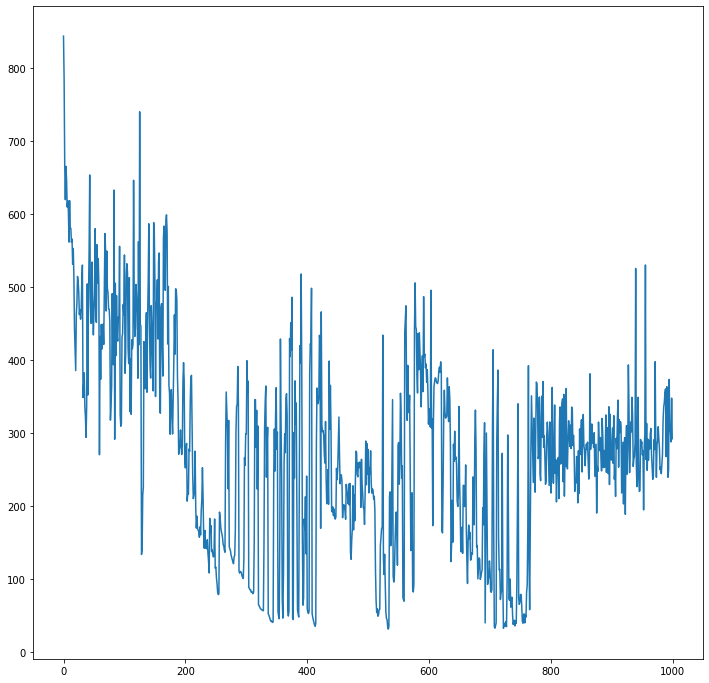

In [35]:
plt.plot(error_values);

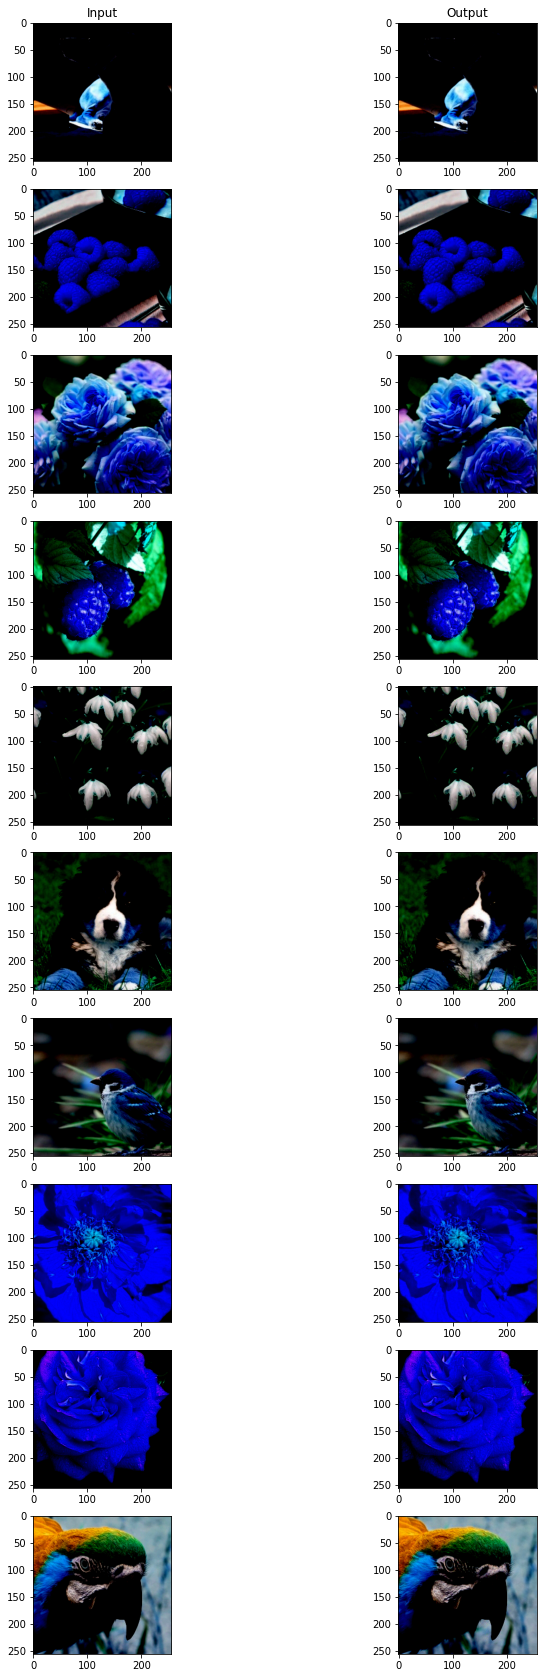

In [28]:
#network testing
matplotlib.rcParams['figure.figsize'] = [12, 30]
fig, axes = plt.subplots(10, 2)

for row_ind in range(10):
    pic = train_data[np.random.randint(0, train_data.shape[0])]
    test = nn(pic)
    axes[row_ind][0].imshow(pic)
    axes[row_ind][1].imshow(test)
axes[0][0].set_title("Input")
axes[0][1].set_title("Output");

**Compressed pictures visualising**

(256, 192)


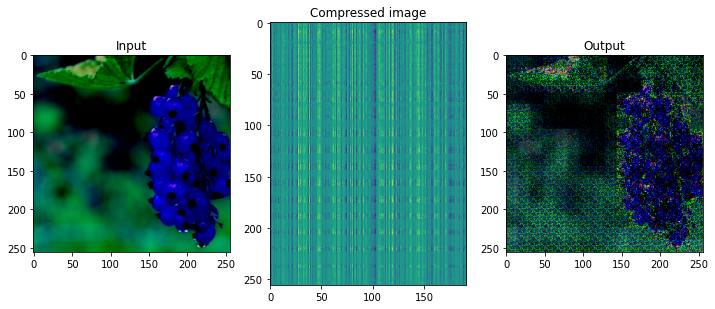

In [36]:
matplotlib.rcParams['figure.figsize'] = [12, 12]

image_ind = np.random.randint(0, train_data.shape[0])
pic = train_data[image_ind]
compressed, test = nn(pic, True)

np.savetxt("{}_compr.csv".format(image_ind), compressed, delimiter=',')
fig, axs = plt.subplots(1,3)
axs[0].imshow(pic)
axs[1].imshow(compressed)
axs[2].imshow(test)
axs[0].set_title("Input")
axs[1].set_title("Compressed image")
axs[2].set_title("Output");

In [37]:
compressed.shape

(256, 192)

**Average loss calculating**

In [ ]:
err_sum = 0.
for image in train_data:
    err_sum += np.abs(nn(image) - image).sum()
err_sum / train_data.shape[0]